# 0. 버전확인

In [38]:
# import tensorflow

# print(tensorflow.__version__)

In [39]:
 # !pip install wandb

In [40]:
# !pip install torch

In [41]:
# !pip install wandb transformers scikit-learn

In [42]:
# !pip install transformers

In [43]:
# !pip install transformers sklearn

# Step 1. 데이터 수집하기
### new_train.csv사용

In [44]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import re

from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import torch
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler  # Mixed precision training

import transformers
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, DistilBertForSequenceClassification, AdamW
from transformers import pipeline

from sklearn.metrics import f1_score
#from sklearn.manifold import TSNE
#from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns


import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print('=3')

=3


In [45]:
train_data_path ='/aiffel/aiffel/workplace/aug_train.csv'
train_data = pd.read_csv(train_data_path)
train_data.head(5)

,Unnamed: 0,idx,class,conversation
0,0,0,협박 대화,네가 선택해 네 가족을 죽여줄까? 죄송합니다.
1,1,1,협박 대화,"""길동 경찰서입니다"" 9시 40분 마트에 폭발물이 터지면 다 죽는 거야."
2,2,2,기타 괴롭힘 대화,왜 그래? 지영아 네가 키 160이지? 그럼 재는 160도 안 되는 거네? 너 군대...
3,3,3,갈취 대화,너 옷 좋아 보인다? 얘 돈 좀 있나 봐 아니에요. 돈 없어요 뒤져서 나오면 넌 죽...
4,4,4,갈취 대화,피부가 따끔거리네요.


In [46]:
data = train_data.copy()

In [47]:
test_data_path ='/aiffel/aiffel/workplace/test.csv'
test_data = pd.read_csv(test_data_path)
test_data.head(5)

,idx,text
0,t_000,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...
1,t_001,우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때? 네? 제가요? ...
2,t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...
3,t_003,이거 들어바 와 이 노래 진짜 좋다 그치 요즘 이 것만 들어 진짜 너무 좋다 내가 ...
4,t_004,아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...


In [48]:
test = test_data.copy()

# Step 2. 데이터 전처리하기
### 5) 데이터 증강 외 모두 적용

#### **1) 한글 불용어 처리  2) 구두점 처리  3) 중복 공백 제거  4) 양쪽 공백 제거   6) 임베딩 방식(모델에서 처리해줌)**

In [49]:
num_samples = len(data)
print("샘플 개수:", num_samples)

샘플 개수: 33496


In [50]:
# 중복 확인
from collections import Counter

data_counts = Counter(data)
duplicates = {item: count for item, count in data_counts.items() if count > 1}

print("중복된 데이터:", duplicates)  # {1: 2} (1이 2번 등장)

중복된 데이터: {}


In [51]:
# 'class' 열과 'idx' 열에 누락값 확인
missing_class = data['class'].isnull().any()
missing_idx = data['idx'].isnull().any()

print("class 열에 누락값이 있습니까?", missing_class)  # True (누락값 있음)
print("idx 열에 누락값이 있습니까?", missing_idx)      # True (누락값 있음)


class 열에 누락값이 있습니까? False
idx 열에 누락값이 있습니까? False


In [52]:
'''
import re

# 한글 불용어 목록
stopwords = [
    "이", "그", "저", "가", "을", "를", "에", "의", "와", "과", "들"
]

def preprocess_korean_text(data):
    processed_texts = []

    for sentence in data:
        # 구두점 처리
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)

        # 중복 공백 제거
        sentence = re.sub(r'\s+', ' ', sentence)

        # 양쪽 공백 제거
        sentence = sentence.strip()

        processed_texts.append(sentence)

    return processed_texts

def remove_stopwords(data, stopwords):
    filtered_texts = []

    for sentence in data:
        # 텍스트를 공백으로 분리하여 단어 리스트 생성
        words = sentence.split()

        # 불용어가 아닌 단어만 필터링
        filtered_words = [word for word in words if word not in stopwords]

        # 필터링된 단어를 다시 문자열로 결합
        filtered_texts.append(' '.join(filtered_words))

    return filtered_texts


# conversation 열에 대해서만 전처리 및 불용어 제거 적용
data['conversation_processed'] = preprocess_korean_text(data['conversation'])
data['conversation_filtered'] = remove_stopwords(data['conversation_processed'], stopwords)

# 결과 확인
print(data[['conversation', 'conversation_processed', 'conversation_filtered']].head())
'''

'\nimport re\n\n# 한글 불용어 목록\nstopwords = [\n    "이", "그", "저", "가", "을", "를", "에", "의", "와", "과", "들"\n]\n\ndef preprocess_korean_text(data):\n    processed_texts = []\n\n    for sentence in data:\n        # 구두점 처리\n        sentence = re.sub(r"([?.!,])", r" \x01 ", sentence)\n\n        # 중복 공백 제거\n        sentence = re.sub(r\'\\s+\', \' \', sentence)\n\n        # 양쪽 공백 제거\n        sentence = sentence.strip()\n\n        processed_texts.append(sentence)\n\n    return processed_texts\n\ndef remove_stopwords(data, stopwords):\n    filtered_texts = []\n\n    for sentence in data:\n        # 텍스트를 공백으로 분리하여 단어 리스트 생성\n        words = sentence.split()\n\n        # 불용어가 아닌 단어만 필터링\n        filtered_words = [word for word in words if word not in stopwords]\n\n        # 필터링된 단어를 다시 문자열로 결합\n        filtered_texts.append(\' \'.join(filtered_words))\n\n    return filtered_texts\n\n\n# conversation 열에 대해서만 전처리 및 불용어 제거 적용\ndata[\'conversation_processed\'] = preprocess_korean_text(data[\'conversation

In [53]:
data

,Unnamed: 0,idx,class,conversation
0,0,0,협박 대화,네가 선택해 네 가족을 죽여줄까? 죄송합니다.
1,1,1,협박 대화,"""길동 경찰서입니다"" 9시 40분 마트에 폭발물이 터지면 다 죽는 거야."
2,2,2,기타 괴롭힘 대화,왜 그래? 지영아 네가 키 160이지? 그럼 재는 160도 안 되는 거네? 너 군대...
3,3,3,갈취 대화,너 옷 좋아 보인다? 얘 돈 좀 있나 봐 아니에요. 돈 없어요 뒤져서 나오면 넌 죽...
4,4,4,갈취 대화,피부가 따끔거리네요.
...,...,...,...,...
33491,33491,33491,기타 괴롭힘 대화,왜 나한테 이러는 거야? 왜 그렇게 무식한데 머리가 이렇게 큰 거야? 그냥 멍청한 ...
33492,33492,33492,갈취 대화,네. 선생님 진정하시고 우리 스스로의 말로 해결합시다.
33493,33493,33493,직장 내 괴롭힘 대화,"""예""라고 제대로 말하고 그렇게 정확하게 대답하는 걸 본 적이 없어."
33494,33494,33494,갈취 대화,내가 줄 수 없어. 우리 구역이니까 우리가 하고 싶은 대로 할 수 있어 좋은 말을 ...


In [54]:
# 열 삭제
data = data.drop(columns=['Unnamed: 0'])
data

,idx,class,conversation
0,0,협박 대화,네가 선택해 네 가족을 죽여줄까? 죄송합니다.
1,1,협박 대화,"""길동 경찰서입니다"" 9시 40분 마트에 폭발물이 터지면 다 죽는 거야."
2,2,기타 괴롭힘 대화,왜 그래? 지영아 네가 키 160이지? 그럼 재는 160도 안 되는 거네? 너 군대...
3,3,갈취 대화,너 옷 좋아 보인다? 얘 돈 좀 있나 봐 아니에요. 돈 없어요 뒤져서 나오면 넌 죽...
4,4,갈취 대화,피부가 따끔거리네요.
...,...,...,...
33491,33491,기타 괴롭힘 대화,왜 나한테 이러는 거야? 왜 그렇게 무식한데 머리가 이렇게 큰 거야? 그냥 멍청한 ...
33492,33492,갈취 대화,네. 선생님 진정하시고 우리 스스로의 말로 해결합시다.
33493,33493,직장 내 괴롭힘 대화,"""예""라고 제대로 말하고 그렇게 정확하게 대답하는 걸 본 적이 없어."
33494,33494,갈취 대화,내가 줄 수 없어. 우리 구역이니까 우리가 하고 싶은 대로 할 수 있어 좋은 말을 ...


In [55]:
# 열 이름 변경
data = data.rename(columns={'conversation_filtered': 'conversation'})
data


,idx,class,conversation
0,0,협박 대화,네가 선택해 네 가족을 죽여줄까? 죄송합니다.
1,1,협박 대화,"""길동 경찰서입니다"" 9시 40분 마트에 폭발물이 터지면 다 죽는 거야."
2,2,기타 괴롭힘 대화,왜 그래? 지영아 네가 키 160이지? 그럼 재는 160도 안 되는 거네? 너 군대...
3,3,갈취 대화,너 옷 좋아 보인다? 얘 돈 좀 있나 봐 아니에요. 돈 없어요 뒤져서 나오면 넌 죽...
4,4,갈취 대화,피부가 따끔거리네요.
...,...,...,...
33491,33491,기타 괴롭힘 대화,왜 나한테 이러는 거야? 왜 그렇게 무식한데 머리가 이렇게 큰 거야? 그냥 멍청한 ...
33492,33492,갈취 대화,네. 선생님 진정하시고 우리 스스로의 말로 해결합시다.
33493,33493,직장 내 괴롭힘 대화,"""예""라고 제대로 말하고 그렇게 정확하게 대답하는 걸 본 적이 없어."
33494,33494,갈취 대화,내가 줄 수 없어. 우리 구역이니까 우리가 하고 싶은 대로 할 수 있어 좋은 말을 ...


In [56]:
# 열 이름 변경
data = data.rename(columns={'class': 'class_label'})
data

,idx,class_label,conversation
0,0,협박 대화,네가 선택해 네 가족을 죽여줄까? 죄송합니다.
1,1,협박 대화,"""길동 경찰서입니다"" 9시 40분 마트에 폭발물이 터지면 다 죽는 거야."
2,2,기타 괴롭힘 대화,왜 그래? 지영아 네가 키 160이지? 그럼 재는 160도 안 되는 거네? 너 군대...
3,3,갈취 대화,너 옷 좋아 보인다? 얘 돈 좀 있나 봐 아니에요. 돈 없어요 뒤져서 나오면 넌 죽...
4,4,갈취 대화,피부가 따끔거리네요.
...,...,...,...
33491,33491,기타 괴롭힘 대화,왜 나한테 이러는 거야? 왜 그렇게 무식한데 머리가 이렇게 큰 거야? 그냥 멍청한 ...
33492,33492,갈취 대화,네. 선생님 진정하시고 우리 스스로의 말로 해결합시다.
33493,33493,직장 내 괴롭힘 대화,"""예""라고 제대로 말하고 그렇게 정확하게 대답하는 걸 본 적이 없어."
33494,33494,갈취 대화,내가 줄 수 없어. 우리 구역이니까 우리가 하고 싶은 대로 할 수 있어 좋은 말을 ...


### MAX LENGTH 정하기

대화의 최소 길이 : 1
대화의 최대 길이 : 121
대화의 평균 길이 : 21.194321710054933


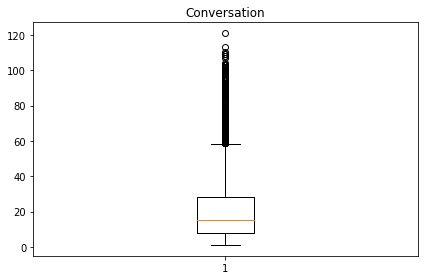

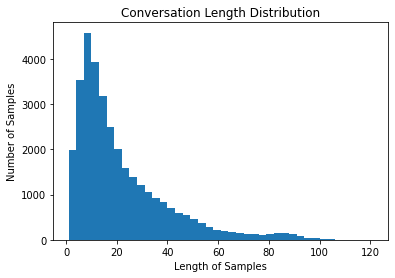

In [57]:
# 길이 분포 출력
conversation_len = [len(s.split()) for s in data['conversation']]
class_label_len = [len(s.split()) for s in data['class_label']]

print('대화의 최소 길이 : {}'.format(np.min(conversation_len)))
print('대화의 최대 길이 : {}'.format(np.max(conversation_len)))
print('대화의 평균 길이 : {}'.format(np.mean(conversation_len)))

# 길이 분포 시각화
plt.subplot(1, 1, 1)
plt.boxplot(conversation_len)
plt.title('Conversation')

plt.tight_layout()
plt.show()

plt.title('Conversation Length Distribution')
plt.hist(conversation_len, bins=40)
plt.xlabel('Length of Samples')
plt.ylabel('Number of Samples')
plt.show()


In [58]:
from sklearn.preprocessing import LabelEncoder
CLASS_NAMES = ['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화', '일반']

label_size = len(CLASS_NAMES)

encoder = LabelEncoder()
encoder.fit(CLASS_NAMES)

data['class_label'] = encoder.transform(data['class_label'])
data.head()

,idx,class_label,conversation
0,0,4,네가 선택해 네 가족을 죽여줄까? 죄송합니다.
1,1,4,"""길동 경찰서입니다"" 9시 40분 마트에 폭발물이 터지면 다 죽는 거야."
2,2,1,왜 그래? 지영아 네가 키 160이지? 그럼 재는 160도 안 되는 거네? 너 군대...
3,3,0,너 옷 좋아 보인다? 얘 돈 좀 있나 봐 아니에요. 돈 없어요 뒤져서 나오면 넌 죽...
4,4,0,피부가 따끔거리네요.


In [59]:
# train 데이터셋의 'class_label' 컬럼을 라벨 인코딩
label_encoder = LabelEncoder()

# 'class_label' 열에 인코딩을 적용하여 숫자로 변환
data['class_label'] = label_encoder.fit_transform(data['class_label'])

# 변환된 데이터 확인
print(data['class_label'].head())

0    4
1    4
2    1
3    0
4    0
Name: class_label, dtype: int64


# step 4. 모델 정의

#### 9-4. KLUE-BERT 가져오기

> t-SNE, 	**작은 데이터셋**의 클러스터링된 패턴을 탐색하거나, 데이터의 **국소적 특성**을 시각화하기 좋음.


**작은 데이터셋인가?**
-> 크기 측면에서 보면, 데이터셋의 크기가 12,092개의 샘플로 되어 있는 중간 크기의 데이터셋  
=> (t-SNE를 사용하는 데 무리가 없는 크기, 매우 크지는 않아서 빠르게 처리가능)



**국소적 특성**
-> 협박과 관련된 문장들이 같은 공간에 모이고, 갈취와 직장 내 괴롭힘은 다른 영역에 모이는지 등 우리의 상식과 비슷한지 확인하고자 함.  
-> 세부적으로 어떤 문장들이 더 유사한지를 탐구

### 1.KLUE-BERT 모델과 토크나이저 로드

In [60]:
# GPU 설정 (가능할 경우)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [61]:
# KLUE-BERT 모델과 토크나이저 로드
tokenizer = BertTokenizer.from_pretrained("klue/bert-base")
model = BertForSequenceClassification.from_pretrained("klue/bert-base", num_labels=len(data['class_label'].unique()))  # 클래스 수에 맞게 설정
model.to(device)

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [62]:
# KLUE-BERT 모델과 토크나이저 로드
# tokenizer = BertTokenizer.from_pretrained("klue/bert-base")
# model = BertModel.from_pretrained("klue/bert-base") # BertForSequenceClassification 대신 BertModel 사용

# model = BertForSequenceClassification.from_pretrained("klue/bert-base")
# ERROR : AttributeError: 'SequenceClassifierOutput' object has no attribute 'last_hidden_state'

**1. 다시 시도 :  모델과 토크나이저 로드 (경량화된 모델사용)**

In [63]:
# DistilBERT 모델과 토크나이저 로드 (경량화된 모델 사용)
# tokenizer = BertTokenizer.from_pretrained("distilbert-base-uncased")
# model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(train_data['class'].unique()))
# model.to(device)

### 2. 텍스트 데이터를 KLUE-BERT 임베딩으로 변환  

시간 진짜 오래 걸림;;;;
image.png
image.png
image.png
image.png

In [64]:
'''# 텍스트를 BERT 임베딩으로 변환하는 함수
def get_bert_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
    with torch.no_grad():  # 모델 학습을 하지 않으므로 gradient 계산을 하지 않음
        outputs = model(**inputs)
    # CLS 토큰의 임베딩만 사용 (배치에서 첫 번째 토큰)
    return outputs.last_hidden_state[:, 0, :].numpy()

# 데이터에서 텍스트 열을 사용하여 BERT 임베딩 계산
embeddings = np.array([get_bert_embeddings(text) for text in data['conversation']])'''


"# 텍스트를 BERT 임베딩으로 변환하는 함수\ndef get_bert_embeddings(text):\n    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)\n    with torch.no_grad():  # 모델 학습을 하지 않으므로 gradient 계산을 하지 않음\n        outputs = model(**inputs)\n    # CLS 토큰의 임베딩만 사용 (배치에서 첫 번째 토큰)\n    return outputs.last_hidden_state[:, 0, :].numpy()\n\n# 데이터에서 텍스트 열을 사용하여 BERT 임베딩 계산\nembeddings = np.array([get_bert_embeddings(text) for text in data['conversation']])"

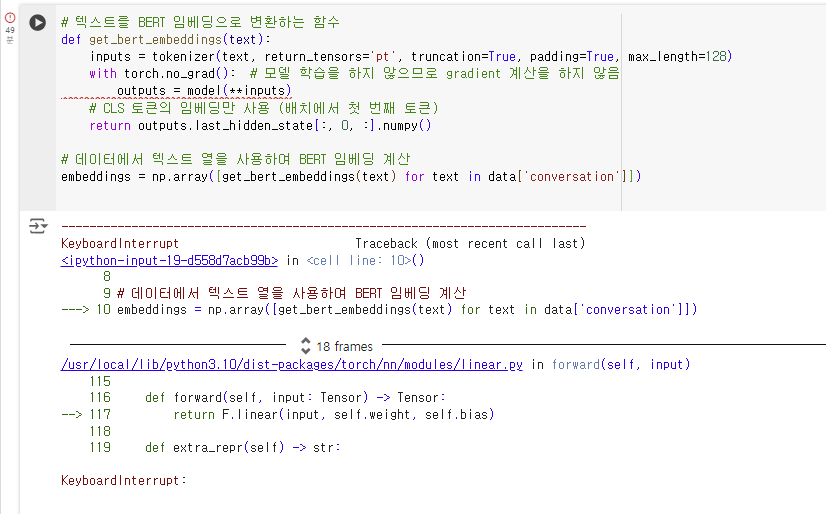

### **다시 시도 : 토크나이징과 데이터 로드**

In [65]:
print(data['class_label'][2],"\n")

1 



In [66]:
# 라벨을 정수형으로 변환 (수정된 부분)
label_mapping = {label: idx for idx, label in enumerate(data['class_label'].unique())}  # 라벨을 정수형으로 변환
data['class_label'] = data['class_label'].map(label_mapping)  # 라벨 매핑 적용


In [67]:
print(data['class_label'][2],"\n")

1 



In [68]:
# 데이터셋 클래스 정의 (토크나이징과 데이터 로드)
class TextDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()

        item = {
            'input_ids': input_ids,
            'attention_mask': attention_mask
        }

        # 라벨이 있는 경우, 정수형 라벨을 사용하도록 수정 (수정된 부분)
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)  # 라벨은 정수형으로 변환됨

        return item

### 훈련 및 테스트 데이터 준비

라벨은 훈련 데이터만 적용하였고, 배치 크기 줄임 64->16

In [69]:
# 훈련 및 테스트 데이터 준비 
train_texts = data['conversation'].tolist()
train_labels = data['class_label'].tolist()

test_texts = test['text'].tolist()  # 라벨 없이 텍스트만 사용
# test_labels는 테스트 데이터에 없으므로 None으로 설정

train_dataset = TextDataset(train_texts, train_labels, tokenizer)
test_dataset = TextDataset(test_texts, tokenizer=tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

각 샘플의 토큰 길이를 구함

In [70]:
# 텍스트 데이터를 토큰화하고 각 샘플의 토큰 길이를 구함
token_lengths = [len(tokenizer.encode(text, truncation=True, padding='max_length', max_length= 128)) for text in data['conversation']]

# 토큰 길이의 평균값 계산
average_token_length = sum(token_lengths) / len(token_lengths)
print(f'평균 토큰 수: {average_token_length}')

평균 토큰 수: 128.0


### 학습 & 평가 설정

In [71]:
# 6. 옵티마이저 설정
optimizer = AdamW(model.parameters(), lr=5e-5)

In [72]:
# 8. 학습 함수 정의
def train_epoch(model, data_loader, optimizer, device):
    model.train()
    losses = []
    correct_predictions = 0
    total = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()

        preds = torch.argmax(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        total += len(labels)
        losses.append(loss.item())

    return correct_predictions.double() / total, np.mean(losses)

In [73]:
# 9. 평가 함수 정의
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            predictions.extend(preds.cpu().numpy())
            if 'labels' in batch:
                true_labels.extend(batch['labels'].cpu().numpy())

    return predictions, true_labels


### F1 Score 계산

In [74]:
# 10.학습 및 평가
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

EPOCHS = 10

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    train_acc, train_loss = train_epoch(model, train_loader, optimizer, device)
    print(f'Train loss: {train_loss}, Train accuracy: {train_acc}')

    # 마지막 에포크에서만 혼동 행렬 및 성능 평가 수행
    if epoch == EPOCHS - 1:
        # 테스트 데이터에서 예측값 추출 및 F1 Score 계산
        predictions, true_labels = evaluate(model, test_loader, device)

        # F1 Score 계산 (테스트 데이터의 라벨이 있는 경우)
        if true_labels:
            f1 = f1_score(true_labels, predictions, average='weighted')
            print(f'F1 Score: {f1}')
            
            # 혼동 행렬 생성 및 시각화
            cm = confusion_matrix(true_labels, predictions)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)
            disp.plot(cmap=plt.cm.Blues)  # 색상 설정은 선택적
            plt.title('Confusion Matrix (Last Epoch)')
            plt.show()
        else:
            print("Test data predictions:", predictions)



Epoch 1/10
Train loss: 0.6686504285074522, Train accuracy: 0.7625686649152138
Epoch 2/10
Train loss: 0.3105408609299916, Train accuracy: 0.8928230236446143
Epoch 3/10
Train loss: 0.18372972124325576, Train accuracy: 0.9372760926677812
Epoch 4/10
Train loss: 0.13624352660166222, Train accuracy: 0.9522032481490328
Epoch 5/10
Train loss: 0.11249437113567709, Train accuracy: 0.9613088129925962
Epoch 6/10
Train loss: 0.09696001209757947, Train accuracy: 0.9659660855027467
Epoch 7/10
Train loss: 0.08950152918403698, Train accuracy: 0.9678170527824218
Epoch 8/10
Train loss: 0.08517026767393905, Train accuracy: 0.969608311440172
Epoch 9/10
Train loss: 0.07718078504475955, Train accuracy: 0.9721459278719847
Epoch 10/10
Train loss: 0.07507955895330083, Train accuracy: 0.9728922856460474
Test data predictions: [2, 3, 1, 4, 1, 0, 0, 4, 1, 2, 0, 1, 3, 3, 3, 0, 4, 1, 0, 1, 0, 1, 1, 2, 2, 3, 1, 1, 3, 2, 2, 0, 1, 2, 0, 1, 1, 2, 0, 2, 4, 2, 3, 2, 1, 3, 0, 2, 1, 0, 2, 1, 2, 3, 3, 1, 1, 4, 1, 1, 2, 0, 0,

In [75]:
# 6. submission.csv 파일 생성
submission = pd.DataFrame({
    'idx': test['idx'],  # 테스트 데이터의 idx 열 사용
    'target': predictions  # 모델 예측 결과 사용
})

submission.to_csv('submission.csv', index=False)  # CSV 파일로 저장

## KLUE-BERT와 t-SNE를 사용한 시각화

주요 단계 요약:
1. KLUE-BERT 모델과 토크나이저 로드 (앞에서 함)  
2. 텍스트 데이터를 KLUE-BERT 임베딩으로 변환 (앞에서 함)   
3. t-SNE를 사용하여 차원 축소  
4. t-SNE 시각화  

## 🍎wandb시각화 

In [76]:
# import wandb
# wandb.login()
#### fa871456018229869f6bec3437e5fd81949f43e6

In [77]:
# WandB 프로젝트 초기화
# wandb.init(project="dim_reduction_example")
# wandb.init(project="klue_bert_tsne_3d")

### wandb시각화 :  t-SNE
**KLUE-BERT로 임베딩 추출 후 t-SNE 시각화**

In [78]:
"""
def extract_embeddings(model, data_loader, device):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model.bert(input_ids=input_ids, attention_mask=attention_mask)
            cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(cls_embeddings)
    return np.vstack(embeddings)
"""

"\ndef extract_embeddings(model, data_loader, device):\n    model.eval()\n    embeddings = []\n    with torch.no_grad():\n        for batch in data_loader:\n            input_ids = batch['input_ids'].to(device)\n            attention_mask = batch['attention_mask'].to(device)\n            outputs = model.bert(input_ids=input_ids, attention_mask=attention_mask)\n            cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()\n            embeddings.append(cls_embeddings)\n    return np.vstack(embeddings)\n"

In [79]:
"""
# 훈련 데이터에서 임베딩 추출
train_embeddings = extract_embeddings(model, train_loader, device)

# t-SNE로 3차원 차원 축소
tsne = TSNE(n_components=3, random_state=42)
train_tsne_3d = tsne.fit_transform(train_embeddings)

# WandB로 3D 시각화
wandb.log({
    "3D t-SNE Visualization": wandb.plot.scatter(
        wandb.Table(data=[[x, y, z, label] for x, y, z, label in zip(
            train_tsne_3d[:, 0], train_tsne_3d[:, 1], train_tsne_3d[:, 2], train_labels
        )],
        columns=["TSNE-1", "TSNE-2", "TSNE-3", "class"]),
        "TSNE-1", "TSNE-2", "TSNE-3", title="3D t-SNE Visualization of KLUE-BERT Embeddings"
    )
})

# WandB 로그 종료
wandb.finish()
"""

'\n# 훈련 데이터에서 임베딩 추출\ntrain_embeddings = extract_embeddings(model, train_loader, device)\n\n# t-SNE로 3차원 차원 축소\ntsne = TSNE(n_components=3, random_state=42)\ntrain_tsne_3d = tsne.fit_transform(train_embeddings)\n\n# WandB로 3D 시각화\nwandb.log({\n    "3D t-SNE Visualization": wandb.plot.scatter(\n        wandb.Table(data=[[x, y, z, label] for x, y, z, label in zip(\n            train_tsne_3d[:, 0], train_tsne_3d[:, 1], train_tsne_3d[:, 2], train_labels\n        )],\n        columns=["TSNE-1", "TSNE-2", "TSNE-3", "class"]),\n        "TSNE-1", "TSNE-2", "TSNE-3", title="3D t-SNE Visualization of KLUE-BERT Embeddings"\n    )\n})\n\n# WandB 로그 종료\nwandb.finish()\n'

### (나중에 시간나면)wandb시각화 :  PCA

In [80]:
"""
# WandB 프로젝트 초기화
# wandb.init(project="dim_reduction_example")

# 예시 데이터: conversation에 정수 인코딩된 데이터가 있다고 가정
# conversation = np.random.randn(100, 300)  # 임의 데이터 예시
'''
# PCA 적용
pca = PCA(n_components=2)
pca_components = pca.fit_transform(conversation)

# t-SNE 적용
tsne = TSNE(n_components=2, random_state=42)
tsne_components = tsne.fit_transform(conversation)

# 시각화 결과를 WandB에 기록
wandb.log({
    "PCA Scatter Plot": wandb.plot.scatter(
        wandb.Table(data=[[x, y] for x, y in zip(pca_components[:, 0], pca_components[:, 1])],
                    columns=["PC1", "PC2"]),
        "PC1", "PC2", title="PCA of Data"
    ),
    "t-SNE Scatter Plot": wandb.plot.scatter(
        wandb.Table(data=[[x, y] for x, y in zip(tsne_components[:, 0], tsne_components[:, 1])],
                    columns=["Dim1", "Dim2"]),
        "Dim1", "Dim2", title="t-SNE of Data"
    )
})
"""

'\n# WandB 프로젝트 초기화\n# wandb.init(project="dim_reduction_example")\n\n# 예시 데이터: conversation에 정수 인코딩된 데이터가 있다고 가정\n# conversation = np.random.randn(100, 300)  # 임의 데이터 예시\n\'\'\'\n# PCA 적용\npca = PCA(n_components=2)\npca_components = pca.fit_transform(conversation)\n\n# t-SNE 적용\ntsne = TSNE(n_components=2, random_state=42)\ntsne_components = tsne.fit_transform(conversation)\n\n# 시각화 결과를 WandB에 기록\nwandb.log({\n    "PCA Scatter Plot": wandb.plot.scatter(\n        wandb.Table(data=[[x, y] for x, y in zip(pca_components[:, 0], pca_components[:, 1])],\n                    columns=["PC1", "PC2"]),\n        "PC1", "PC2", title="PCA of Data"\n    ),\n    "t-SNE Scatter Plot": wandb.plot.scatter(\n        wandb.Table(data=[[x, y] for x, y in zip(tsne_components[:, 0], tsne_components[:, 1])],\n                    columns=["Dim1", "Dim2"]),\n        "Dim1", "Dim2", title="t-SNE of Data"\n    )\n})\n'

## 파이프라인을 이용한 테스트

In [81]:
"""
# KLUE-BERT 토크나이저로 토큰화 및 인코딩
inputs = tokenizer(
    processed_texts.tolist(),  # 전처리된 텍스트 리스트
    return_tensors="pt",       # PyTorch 텐서로 반환
    padding=True,              # 패딩 적용
    truncation=True,           # 최대 길이 초과시 잘라내기
    max_length=128             # 최대 길이 설정 (128 토큰)
)
"""

'\n# KLUE-BERT 토크나이저로 토큰화 및 인코딩\ninputs = tokenizer(\n    processed_texts.tolist(),  # 전처리된 텍스트 리스트\n    return_tensors="pt",       # PyTorch 텐서로 반환\n    padding=True,              # 패딩 적용\n    truncation=True,           # 최대 길이 초과시 잘라내기\n    max_length=128             # 최대 길이 설정 (128 토큰)\n)\n'

In [82]:
"""
# KLUE-BERT 모델에 입력하여 임베딩 또는 예측값 얻기
with torch.no_grad():  # 학습이 아닌 예측을 수행하므로 gradient 계산하지 않음
    outputs = model(**inputs)

# 모델 출력 확인
# CLS 토큰에 해당하는 임베딩 벡터 추출
cls_embedding = outputs.last_hidden_state[:, 0, :]  # CLS 토큰 임베딩
"""

'\n# KLUE-BERT 모델에 입력하여 임베딩 또는 예측값 얻기\nwith torch.no_grad():  # 학습이 아닌 예측을 수행하므로 gradient 계산하지 않음\n    outputs = model(**inputs)\n\n# 모델 출력 확인\n# CLS 토큰에 해당하는 임베딩 벡터 추출\ncls_embedding = outputs.last_hidden_state[:, 0, :]  # CLS 토큰 임베딩\n'

In [83]:
"""
# 파이프라인을 이용한 테스트
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# 예시 문장 테스트
text = "이 문장은 KLUE-BERT 모델을 테스트하는 예시입니다."
result = nlp(text)

print(result)
"""

'\n# 파이프라인을 이용한 테스트\nnlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)\n\n# 예시 문장 테스트\ntext = "이 문장은 KLUE-BERT 모델을 테스트하는 예시입니다."\nresult = nlp(text)\n\nprint(result)\n'

In [84]:
"""
# 예시 문장 테스트
text = "이 문장은 KLUE-BERT 모델을 테스트하는 예시입니다."
result = nlp(text)

print(result)
"""

'\n# 예시 문장 테스트\ntext = "이 문장은 KLUE-BERT 모델을 테스트하는 예시입니다."\nresult = nlp(text)\n\nprint(result)\n'

In [85]:
"""
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("klue/bert-base")
print(model.config.id2label)
"""

'\nfrom transformers import BertForSequenceClassification\n\nmodel = BertForSequenceClassification.from_pretrained("klue/bert-base")\nprint(model.config.id2label)\n'